## Import Libraries

In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import os 
from tensorflow import keras
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Softmax,MaxPool2D,Flatten
from tensorflow.keras.models import Sequential
import xml.etree.ElementTree as ET
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

## Get Data

In [2]:
# Let's create paths
images_path = []
annotations_path = []

for dirname, _, filenames in os.walk('data'):
    for file in filenames:
        file_path = os.path.join(dirname, file)
        if file_path[-3:]=='xml':
            annotations_path.append(file_path)
        else:
            images_path.append(file_path)

In [3]:
#create a dataframe to parse the XML file 
df=pd.DataFrame(columns=['file_name', 'label', 'xmin', 'ymin', 'xmax', 'ymax'])

for xml_file in annotations_path:
    tree = ET.parse(xml_file)
    root = tree.getroot()
    file_name = root.find('filename').text
    for obj in root.findall('object'):
        row = {
            'file_name': file_name,
            'label': obj.find('name').text,
            'xmin': int(obj.find('bndbox').find('xmin').text),
            'ymin': int(obj.find('bndbox').find('ymin').text),
            'xmax': int(obj.find('bndbox').find('xmax').text),
            'ymax': int(obj.find('bndbox').find('ymax').text)
        }
        df = df.append(row, ignore_index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_2124\1499314005.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_2124\1499314005.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_2124\1499314005.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_2124\1499314005.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykern

In [4]:
df.head(20)

,file_name,label,xmin,ymin,xmax,ymax
0,maksssksksss0.png,without_mask,79,105,109,142
1,maksssksksss0.png,with_mask,185,100,226,144
2,maksssksksss0.png,without_mask,325,90,360,141
3,maksssksksss1.png,with_mask,321,34,354,69
4,maksssksksss1.png,with_mask,224,38,261,73
5,maksssksksss1.png,with_mask,299,58,315,81
6,maksssksksss1.png,with_mask,143,74,174,115
7,maksssksksss1.png,with_mask,74,69,95,99
8,maksssksksss1.png,with_mask,191,67,221,93
9,maksssksksss1.png,with_mask,21,73,44,93


## Crop images

In [2]:
images_dir='data/images/'

def crop_image(file, xmin, ymin, xmax, ymax,images_dir='data/images/'):
    img = cv2.imread(images_dir+file)
    img=np.array(img)
    cropped_image = img[ymin:ymax, xmin:xmax]
    final_image=cv2.resize(cropped_image,(50,50))
    return final_image

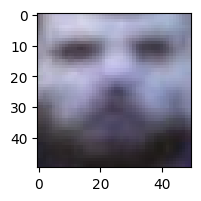

(50, 50, 3)


In [8]:
#testing the function
file=df.iloc[0]

test_img=crop_image(file.file_name,file.xmin,file.ymin,file.xmax,file.ymax,images_dir='data/images/')
plt.figure(figsize=(2,2))
plt.imshow(test_img)
plt.show()
print(test_img.shape)

In [127]:
len(df)

4072

## Create Datasets

In [9]:
images=[]
labels=[]

for i in range(len(df)):
    file=df.iloc[i]
    cropped_image=crop_image(file.file_name,file.xmin,file.ymin,file.xmax,file.ymax,images_dir='data/images/')
    scaled_image=cropped_image/255
    image_label=file.label
    images.append(scaled_image)
    labels.append(image_label)
    

In [10]:
le = preprocessing.LabelEncoder()
labels_encoder = le.fit_transform(labels)
targets = np.array(labels_encoder)

In [11]:
X_train,X_test,y_train,y_test=train_test_split(images,targets,random_state=42,test_size=0.1)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Create tf.Dataset 

In [13]:
def create_train(X,y,batch_size=32):
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.batch(batch_size)
    return data_batch
    
def create_valid(X,y,batch_size=32):
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data_batch = data.batch(batch_size)
    return data_batch

def create_test(X,batch_size=32):
    data=tf.data.Dataset.from_tensor_slices(tf.constant(X))
    data_batch = data.batch(batch_size)
    return data_batch

train_data=create_train(X_train,y_train)
test_data=create_test(X_test)
validation_data=create_valid(X_val,y_val)

## Build the Model

In [14]:
model1=Sequential([
    Conv2D(16,(3,3),activation='relu',padding='same'),
    MaxPool2D(),
    
    Conv2D(32,(3,3),activation='relu',padding='same'),
    MaxPool2D(),
    
    Conv2D(48,(3,3),activation='relu',padding='same'),
    MaxPool2D(),
    
    Flatten(),
    
    Dense(128,activation='relu'),
    
    Dropout(0.1),
    
    Dense(3,activation='softmax'),])

model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"])

hist1=model1.fit(train_data,epochs=20,validation_data=validation_data)

Epoch 1/20
92/92 [==============================] - 8s 77ms/step - loss: 0.3785 - accuracy: 0.8669 - val_loss: 0.2447 - val_accuracy: 0.9263
Epoch 2/20
92/92 [==============================] - 7s 76ms/step - loss: 0.2032 - accuracy: 0.9406 - val_loss: 0.2389 - val_accuracy: 0.9291
Epoch 3/20
92/92 [==============================] - 7s 72ms/step - loss: 0.1901 - accuracy: 0.9389 - val_loss: 0.2621 - val_accuracy: 0.9332
Epoch 4/20
92/92 [==============================] - 7s 79ms/step - loss: 0.1869 - accuracy: 0.9406 - val_loss: 0.2203 - val_accuracy: 0.9372
Epoch 5/20
92/92 [==============================] - 7s 74ms/step - loss: 0.1649 - accuracy: 0.9437 - val_loss: 0.2054 - val_accuracy: 0.9482
Epoch 6/20
92/92 [==============================] - 7s 79ms/step - loss: 0.1655 - accuracy: 0.9461 - val_loss: 0.2081 - val_accuracy: 0.9345
Epoch 7/20
92/92 [==============================] - 7s 78ms/step - loss: 0.1385 - accuracy: 0.9488 - val_loss: 0.1890 - val_accuracy: 0.9386
Epoch 8/20
92

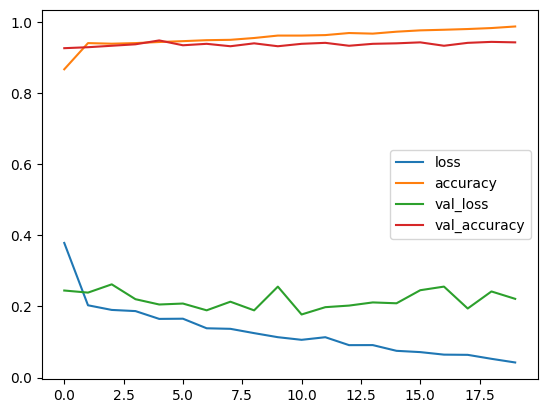

In [15]:
#Evaluate the data
pd.DataFrame(hist1.history).plot()
plt.show()

In [16]:
#Save the Model
model1.save('Mask.h5')

In [3]:
#Load the Model
model1=tf.keras.models.load_model('Mask.h5')

## make predictions on test set 


In [17]:
test_predictions=model1.predict(test_data).argmax(axis=1)

13/13 [==============================] - 0s 21ms/step


In [18]:
len(test_predictions)

408

<AxesSubplot:>

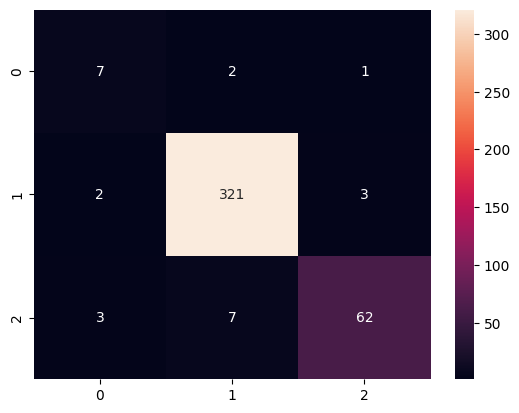

In [19]:
sns.heatmap(confusion_matrix(y_test,test_predictions),annot=True, fmt='g')

In [181]:
print(classification_report(test_predictions,y_test))

              precision    recall  f1-score   support

           0       0.80      0.53      0.64        15
           1       0.98      0.99      0.98       322
           2       0.90      0.92      0.91        71

    accuracy                           0.96       408
   macro avg       0.89      0.81      0.84       408
weighted avg       0.96      0.96      0.96       408



In [136]:
data_iterator=train_data.as_numpy_iterator()
batch=data_iterator.next()

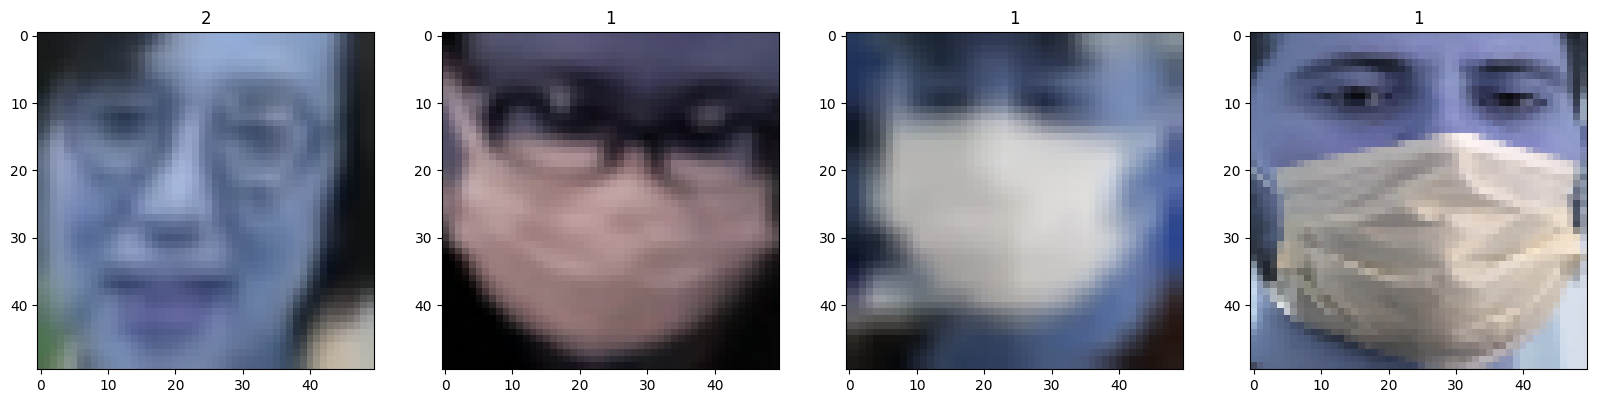

In [137]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for i,image in enumerate(batch[0][0:4]):
  ax[i].imshow(image)
  ax[i].title.set_text(batch[1][i])

## Make Predictions using webcam picture

In [4]:
def take_image():
    cap = cv2.VideoCapture(0)
    if cap.isOpened():
        ret, frame = cap.read()
        cv2.imwrite('webcamphoto.jpg', frame)
        test_img=cv2.imread('webcamphoto.jpg')
    cap.release()
    return test_img

In [5]:
def crop_selfie(image, xmin, ymin, xmax, ymax):
    cropped_image = image[ymin:ymax, xmin:xmax]
    final_image=cv2.resize(cropped_image,(50,50))
    return final_image

In [6]:
def process_selfie(image):
    haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray_image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces_rect = haar_cascade.detectMultiScale(
    gray_image, scaleFactor=1.1, minNeighbors=9,minSize=(50, 50))
    for (x, y, w, h) in faces_rect:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            im_cropped=crop_selfie(image,x,y,x+w,y+h)
            im_resized = cv2.resize(im_cropped, (50, 50))
            im_resized = im_resized / 255.0
            return im_resized

In [7]:
def evaluate_selfie():
    test_img=take_image()
    test_img=process_selfie(test_img)
    plt.imshow(test_img)
    test_img=np.expand_dims(test_img, axis=0)
    result=model1.predict(tf.constant(test_img)).argmax(axis=1)
    if result==1:
        print('The Mask is Worn Correctly')
    elif result==0:
        print('The Mask is Worn Badly')
    else:
        print('No Mask')

1/1 [==============================] - 0s 22ms/step
No Mask


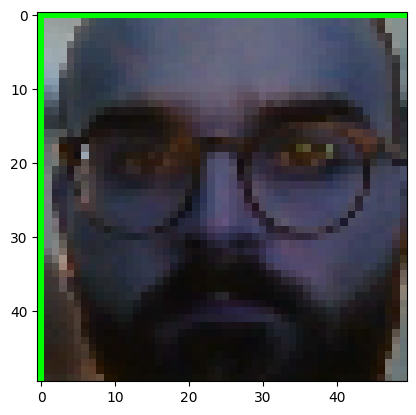

In [79]:
evaluate_selfie()

## Make Prediction for a Multiperson image

In [69]:
def evaluate_picture(image,model):
    haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray_image=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces_rect = haar_cascade.detectMultiScale(
    image, scaleFactor=1.1, minNeighbors=9,minSize=(50, 50))
    for (x, y, w, h) in faces_rect:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            im_cropped=crop_selfie(image,x,y,x+w,y+h)
            im_resized = cv2.resize(im_cropped, (50, 50))
            im_resized = im_resized / 255.0
            test_img=np.expand_dims(im_resized, axis=0)
            test_img=tf.constant(test_img)
            result = model.predict(test_img).argmax(axis=1)
            plt.figure(figsize=(10,5))
            if result==1:
                print('The Mask is Worn Correctly')
                plt.imshow(im_cropped)
            elif result==0:
                print('The Mask is Worn Badly')
                plt.imshow(im_cropped)
            else:
                print('No Mask')
                plt.imshow(im_cropped)

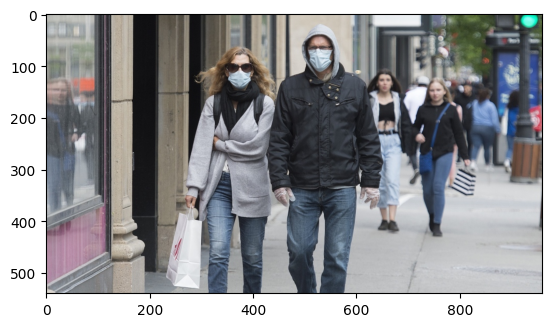

In [78]:
image=cv2.imread('image.jpg')

plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
plt.show()

1/1 [==============================] - 0s 24ms/step
The Mask is Worn Correctly
1/1 [==============================] - 0s 23ms/step
The Mask is Worn Correctly


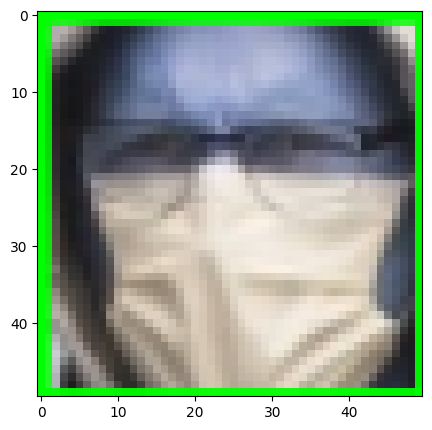

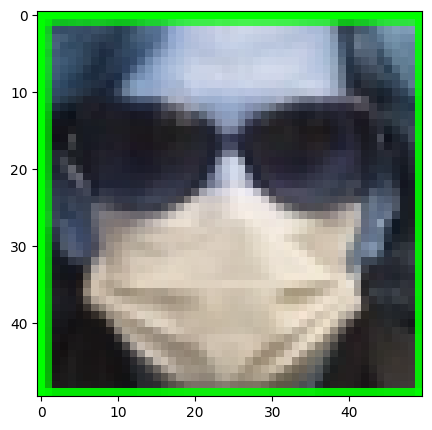

In [76]:
evaluate_picture(image,model1)